# Named entity recognition with Bert

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os # The OS module in python provides functions for interacting with the operating system
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/entity-annotated-corpus/ner.csv
/kaggle/input/entity-annotated-corpus/ner_dataset.csv


In [2]:
pip install transformers

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Load the data

In [3]:
import pandas as pd # data processing
import numpy as np ## linear algebra
from tqdm import tqdm, trange# for progress bar

In [4]:
data = pd.read_csv("../input/entity-annotated-corpus/ner_dataset.csv", encoding="latin1").fillna(method="ffill")
#This is the extract from GMB corpus which is tagged, annotated and built specifically to train the classifier to predict named entities such as name, location, etc.
#Total Words Count = 1354149
#Target Data Column: "tag"

data.tail(10)# show last 10 rows

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [6]:
data.isnull()

,Sentence #,Word,POS,Tag
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
1048570,False,False,False,False
1048571,False,False,False,False
1048572,False,False,False,False
1048573,False,False,False,False


In [7]:
data.describe()

,Sentence #,Word,POS,Tag
count,1048575,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 22480,the,NN,O
freq,104,52573,145807,887908


In [8]:
data['POS'].value_counts()

NN      145807
NNP     131426
IN      120996
DT       98454
JJ       78412
NNS      75840
.        47831
VBD      39379
,        32757
VBN      32328
VBZ      24960
CD       24695
VB       24211
CC       23716
TO       23061
RB       20252
VBG      19125
VBP      16158
PRP      13318
POS      11257
PRP$      8655
MD        6973
``        3728
WDT       3698
JJS       3034
JJR       2967
WP        2542
NNPS      2521
RP        2490
WRB       2184
$         1149
RBR       1055
:          795
RRB        679
LRB        678
EX         663
RBS        296
;          214
PDT        147
WP$         99
UH          24
FW           1
Name: POS, dtype: int64

In [9]:
data['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [10]:
data['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [11]:
data['POS'].unique()

array(['NNS', 'IN', 'VBP', 'VBN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'CC',
       'JJ', '.', 'VBD', 'WP', '``', 'CD', 'PRP', 'VBZ', 'POS', 'VBG',
       'RB', ',', 'WRB', 'PRP$', 'MD', 'WDT', 'JJR', ':', 'JJS', 'WP$',
       'RP', 'PDT', 'NNPS', 'EX', 'RBS', 'LRB', 'RRB', '$', 'RBR', ';',
       'UH', 'FW'], dtype=object)

In [12]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
#to retrieve sentences with their POS and tags (target is tag)

In [13]:
getter = SentenceGetter(data)#Get all sentences

In [14]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]  ##This is how the sentences in the dataset look like.
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [15]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]##this is how labels look like.
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [16]:
tag_values = list(set(data["Tag"].values))#Create dictionary of tags to map labels to numbers.
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [17]:
tag_values

['I-art',
 'I-nat',
 'B-nat',
 'I-per',
 'B-org',
 'B-gpe',
 'I-org',
 'I-eve',
 'B-eve',
 'B-art',
 'I-gpe',
 'I-tim',
 'B-geo',
 'O',
 'B-per',
 'B-tim',
 'I-geo',
 'PAD']

In [18]:
tag2idx

{'I-art': 0,
 'I-nat': 1,
 'B-nat': 2,
 'I-per': 3,
 'B-org': 4,
 'B-gpe': 5,
 'I-org': 6,
 'I-eve': 7,
 'B-eve': 8,
 'B-art': 9,
 'I-gpe': 10,
 'I-tim': 11,
 'B-geo': 12,
 'O': 13,
 'B-per': 14,
 'B-tim': 15,
 'I-geo': 16,
 'PAD': 17}

# Apply Bert
# Prepare the sentences and labels

In [19]:
import torch##is a python package that provides two high-level features: -Tensor computation (like numpy) with strong GPU acceleration - 
#Deep Neural Networks built on a tape-based autograd system

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#DL=Split our data into batches &Shuffle our data ,RS=Samples elements randomly. If without replacement, then sample from a shuffled dataset.,
##SS=keeps Elements in the sample order, always in the same order.
from transformers import BertTokenizer, BertConfig
###This tokenizer inherits from PreTrainedTokenizer which contains most of the methods. Users should refer to the superclass for more information regarding methods.
##It is used to instantiate an BERT model according to the specified arguments, defining the model architecture.

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'1.5.1'

In [20]:
MAX_LEN = 75 #We will limit our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the Bert paper. 
#Note, that Bert natively supports sequences of up to 512 tokens.
bs = 32

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [22]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 
## 12-layer, 768-hidden, 12-heads, 110M parameters.Trained on cased English text.

##The Bert implementation comes with a pretrained tokenizer and a definied vocabulary. We load the one related to the smallest pre-trained model bert-base-cased. 

Now we tokenize all sentences

In [24]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [25]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [26]:
tokenized_texts_and_labels

[(['Thousands',
   'of',
   'demons',
   '##tra',
   '##tors',
   'have',
   'marched',
   'through',
   'London',
   'to',
   'protest',
   'the',
   'war',
   'in',
   'Iraq',
   'and',
   'demand',
   'the',
   'withdrawal',
   'of',
   'British',
   'troops',
   'from',
   'that',
   'country',
   '.'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-geo',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-geo',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-gpe',
   'O',
   'O',
   'O',
   'O',
   'O']),
 (['Iranian',
   'officials',
   'say',
   'they',
   'expect',
   'to',
   'get',
   'access',
   'to',
   'sealed',
   'sensitive',
   'parts',
   'of',
   'the',
   'plant',
   'Wednesday',
   ',',
   'after',
   'an',
   'I',
   '##A',
   '##EA',
   'surveillance',
   'system',
   'begins',
   'functioning',
   '.'],
  ['B-gpe',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-tim',
   'O',
  

In [27]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


Next, we cut and pad the token and label sequences to our desired length.

In [28]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [29]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


The Bert model supports something called attention_mask, which is similar to the masking in keras. So here we create the mask to ignore the padded elements in the sequences.

In [30]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [31]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [32]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [33]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

# Setup the Bert model for finetuning

The pytorch-pretrained-bert package provides a BertForTokenClassification class for token-level predictions. BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel. The token-level classifier is a linear layer that takes as input the last hidden state of the sequence. We load the pre-trained bert-base-uncased model and provide the number of possible labels.

In [34]:
import transformers
from transformers import BertForTokenClassification, AdamW ## is an optimizer with weight decay fixed that can be used to fine-tuned models, 
#Bert Model with a token classification head on top (a linear layer on top of the hidden-states output) e.g. for Named-Entity-Recognition (NER) tasks.

transformers.__version__


'2.11.0'

In [35]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


In [36]:
model.cuda(); #Now we have to pass the model parameters to the GPU.



##Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. A common choice is the AdamW optimizer. We also add some weight_decay as regularization to the main weight matrices. If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed. This will still give you a good performance.

In [37]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [38]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [39]:
pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7423 sha256=a0f9086dba860356f6729f9eb4368fab2c952f10fc2003a8d119eace19b64b3c
  Stored in directory: /root/.cache/pip/wheels/dc/cc/62/a3b81f92d35a80e39eb9b2a9d8b31abac54c02b21b2d466edc
Successfully built seqeval
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Fit BERT for named entity recognition

In [40]:
from seqeval.metrics import f1_score, accuracy_score

First we define some metrics, we want to track while training. We use the f1_score from the seqeval package. You can find more details here. And we use simple accuracy on a token level comparable to the accuracy in keras.

In [41]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
         ###############Bug fix code####################
        b_input_ids = b_input_ids.type(torch.LongTensor)
        b_input_mask = b_input_mask.type(torch.LongTensor)
        b_labels = b_labels.type(torch.LongTensor)

        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
         ############################################
            
            
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.18781205694197373
Validation loss: 0.1366674595574538
Validation Accuracy: 0.9570583972859918


Epoch:  33%|███▎      | 1/3 [06:20<12:41, 380.62s/it]

Validation F1-Score: 0.8121500391354085

Average train loss: 0.10960340714033795
Validation loss: 0.1239406885455052
Validation Accuracy: 0.961381377424986


Epoch:  67%|██████▋   | 2/3 [12:39<06:20, 380.22s/it]

Validation F1-Score: 0.8283448604817554

Average train loss: 0.08212072016868749
Validation loss: 0.12742052418490252
Validation Accuracy: 0.9623036131879714


Epoch: 100%|██████████| 3/3 [19:01<00:00, 380.46s/it]

Validation F1-Score: 0.832193519486337



# Visualize the training loss

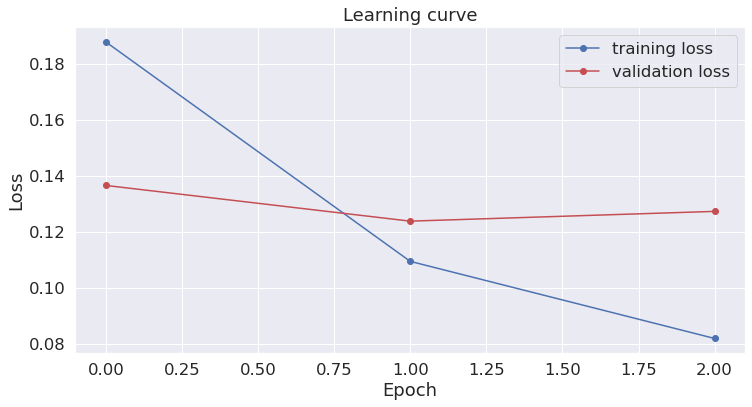

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Apply the model to a new sentenceApply the model to a new sentence

In [43]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""

In [44]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [45]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [46]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [47]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
B-per	Mr
B-per	.
I-per	Trump
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	Fox
I-org	News
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]
